# _BEEM biomass estimation on real data_
This notebook records the code used for analyzing data from [Props _et. al._ (2016)](http://www.nature.com/ismej/journal/v11/n2/full/ismej2016117a.html). We thank the authors for providing us with the raw OTU table.

## Load required packages

In [1]:
## https://gist.github.com/stevenworthington/3178163
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

# usage
packages <- c("ggplot2", "foreach",'doMC','lokern', 'pspline', 'monomvn', "reshape2", "RColorBrewer", "grid", "RCurl")
ipak(packages)

Loading required package: ggplot2
Loading required package: foreach
Loading required package: doMC
Loading required package: iterators
Loading required package: parallel
Loading required package: lokern
Loading required package: pspline
Loading required package: monomvn
Loading required package: pls

Attaching package: ‘pls’

The following object is masked from ‘package:stats’:

    loadings

Loading required package: lars
Loaded lars 1.2

Loading required package: MASS
Loading required package: reshape2
Loading required package: RColorBrewer
Loading required package: grid
Loading required package: RCurl
Loading required package: bitops


ggplot2      foreach         doMC       lokern      pspline      monomvn 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
    reshape2 RColorBrewer         grid        RCurl 
        TRUE         TRUE         TRUE         TRUE

## Setup ggplot theme used for ploting

In [2]:
figtheme <- theme_bw() + 
  theme(text = element_text(size=15,face='bold'),panel.border  = element_rect(colour = "black",size=1.5),
        axis.title.y=element_text(margin=margin(0,8,0,0)),axis.title.x=element_text(margin=margin(8,0,0,0)),
        plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm"),
        plot.title = element_text(margin=margin(0,0,8,0)))
theme_set(figtheme)

## Access Dropbox files

In [3]:
source.dropbox = function(dropbox.url, targetFile) {
    ### Adapted from http://rstudio-pubs-static.s3.amazonaws.com/10162_c939e11b01c54cc9afda69b4dd0c62fe.html
    library(RCurl)
    setwd(tempdir())
    destfile = targetFile
    # use regex to get the piece of the Dropbox URL we need
    matches <- regexpr("(/s/.*)", dropbox.url, perl = TRUE, ignore.case = TRUE)
    result <- attr(matches, "capture.start")[, 1]
    attr(result, "match.length") <- attr(matches, "capture.length")[, 1]
    dropbox.tail = regmatches(dropbox.url, result)
    dburl = paste("https://dl.dropbox.com", dropbox.tail, sep = "")
    x = getBinaryURL(dburl, followlocation = TRUE, ssl.verifypeer = FALSE)
    writeBin(x, destfile, useBytes = TRUE)
}
##https://www.dropbox.com/s/1r8yaidrp5vjjo0/emFunctions.r?dl=0

## Download data

In [4]:
source.dropbox("https://www.dropbox.com/s/eszf3i5trovzau6/metadata.sel.txt", "~/beem/isme_analysis/metadata.sel.txt")
source.dropbox("https://www.dropbox.com/s/2euco6mn6vy7dzn/counts.sel.txt", "~/beem/isme_analysis/counts.sel.txt")
source.dropbox("https://www.dropbox.com/s/5gknlebczb8fyf0/biomass.sel.txt", "~/beem/isme_analysis/biomass.sel.txt")
source.dropbox("https://www.dropbox.com/s/7wgk65unufehvx6/biomass.sel.metagenomeSeq.txt", "~/beem/isme_analysis/biomass.sel.metagenomeSeq.txt")

## Load data and preprosessing

In [5]:
source('~/beem/emFunctions.r')
# metadata
meta <- read.table('~/beem/isme_analysis/metadata.sel.txt', head =T)
meta$purterbID <- 0
# counts
df.counts <- read.table('~/beem/isme_analysis/counts.sel.txt', head =T,row.names=1, comment.char = "!", sep='\t')
## tss counts
df.counts.tss <- apply(df.counts, 2, function(x) x/sum(x))
## true biomass from flow cytometry
biomass.true <- read.table('~/beem/isme_analysis/biomass.sel.txt', head=T)$mass
## biomass calculated with metagenomeSeq (CSS)
biomass.css <- read.table('~/beem/isme_analysis/biomass.sel.metagenomeSeq.txt',head=T)$mass
## keep high abundant otus
fil <- apply(df.counts.tss,1,mean)>0.001
df.counts.sel <- df.counts.tss[fil,]
## biomass for selected otus
biomass.true.sel <- biomass.true*colSums(df.counts.sel)
## biomass for css biomass
biomass.css.sel <- biomass.css*colSums(df.counts.sel)
## scale counts to a defined median
scaling <- 1e5
dat <- df.counts.sel/median(colSums(df.counts.sel)) * scaling

## Run BEEM
* Note: This is time consuming and preferred to be parallelized with parameter `ncpu`.

In [6]:
res <- EM(dat=dat, meta=meta, dev=10,
          verbose=TRUE,
          refSp=3,
          min_iter = 50,epsilon = 0.5, max_iter = 100,
          ncpu=4, scaling = scaling,seed=0)


Preprocessing data ...
##Iteration 1
####solve alpha and beta (E step)
####normalize (M step)####


[1] 1.00446


##########################
##Iteration 2
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.3566788


##########################
##Iteration 3
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1992268


##########################
##Iteration 4
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.201743


##########################
##Iteration 5
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2015124


##########################
##Iteration 6
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1970698


##########################
##Iteration 7
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1931769


##########################
##Iteration 8
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1904962


##########################
##Iteration 9
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1937478


##########################
##Iteration 10
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1911357


##########################
##Iteration 11
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1980321


##########################
##Iteration 12
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1955227


##########################
##Iteration 13
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1994466


##########################
##Iteration 14
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1972926


##########################
##Iteration 15
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2017512


##########################
##Iteration 16
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2025139


##########################
##Iteration 17
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2005358


##########################
##Iteration 18
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2075827


##########################
##Iteration 19
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2073697


##########################
##Iteration 20
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2058897


##########################
##Iteration 21
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2085247


##########################
##Iteration 22
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2121234


##########################
##Iteration 23
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2227487


##########################
##Iteration 24
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2267409


##########################
##Iteration 25
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2250071


##########################
##Iteration 26
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2263697


##########################
##Iteration 27
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2255525


##########################
##Iteration 28
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2256397


##########################
##Iteration 29
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2232945


##########################
##Iteration 30
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.224653


##########################
##Iteration 31
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2237786


##########################
##Iteration 32
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2228237


##########################
##Iteration 33
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2216852


##########################
##Iteration 34
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2199041


##########################
##Iteration 35
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2199823


##########################
##Iteration 36
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2204956


##########################
##Iteration 37
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2215957


##########################
##Iteration 38
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2196336


##########################
##Iteration 39
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2184789


##########################
##Iteration 40
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2189766


##########################
##Iteration 41
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2186621


##########################
##Iteration 42
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2152752


##########################
##Iteration 43
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2178677


##########################
##Iteration 44
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2212938


##########################
##Iteration 45
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2208963


##########################
##Iteration 46
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2186794


##########################
##Iteration 47
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2184953


##########################
##Iteration 48
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2157223


##########################
##Iteration 49
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2136324


##########################
##Iteration 50
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2140962


##########################
##Iteration 51
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2115895


##########################
##Iteration 52
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2125884


##########################
##Iteration 53
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.207952


##########################
##Iteration 54
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2099771


##########################
##Iteration 55
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.207968


##########################
##Iteration 56
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2058828


##########################
##Iteration 57
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2052652


##########################
##Iteration 58
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2036762


##########################
##Iteration 59
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2049377


##########################
##Iteration 60
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2025172


##########################
##Iteration 61
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2037439


##########################
##Iteration 62
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2020157


##########################
##Iteration 63
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2007241


##########################
##Iteration 64
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2012965


##########################
##Iteration 65
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2006041


##########################
##Iteration 66
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1993037


##########################
##Iteration 67
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1984201


##########################
##Iteration 68
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1984775


##########################
##Iteration 69
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1963


##########################
##Iteration 70
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1955285


##########################
##Iteration 71
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1958225


##########################
##Iteration 72
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1929888


##########################
##Iteration 73
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1922201


##########################
##Iteration 74
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1900255


##########################
##Iteration 75
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1895013


##########################
##Iteration 76
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1874597


##########################
##Iteration 77
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.186727


##########################
##Iteration 78
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1856019


##########################
##Iteration 79
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1846934


##########################
##Iteration 80
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1828119


##########################
##Iteration 81
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1829801


##########################
##Iteration 82
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1842101


##########################
##Iteration 83
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1820383


##########################
##Iteration 84
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1806817


##########################
##Iteration 85
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1809141


##########################
##Iteration 86
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1805846


##########################
##Iteration 87
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1816828


##########################
##Iteration 88
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1796697


##########################
##Iteration 89
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1797698


##########################
##Iteration 90
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1806244


##########################
##Iteration 91
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1809271


##########################
##Iteration 92
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.182759


##########################
##Iteration 93
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1896161


##########################
##Iteration 94
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.1982286


##########################
##Iteration 95
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2147872


##########################
##Iteration 96
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2259429


##########################
##Iteration 97
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2413509


##########################
##Iteration 98
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2391842


##########################
##Iteration 99
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2409839


##########################
##Iteration 100
####solve alpha and beta (E step)
####normalize (M step)####


[1] 0.2433784


##########################


## Gather data for plots

In [7]:
trace.mse <- res$trace.mse
min.mse <- min(trace.mse)
trace.mse[1:50] <- Inf
em.idx <- which((trace.mse-min.mse) < res$epsilon*min.mse)
biomass <- apply(res$trace.biomass[,em.idx],1,median)

plot.dat.biomass <- data.frame("Flow cytometry"=biomass.true.sel,
                               "BEEM estimates"=biomass/scaling*median(biomass.true.sel),
                               "CSS normalized"=biomass.css.sel/median(biomass.css.sel)*median(biomass.true.sel),
                               time=meta$measurementID,
                               replicate=paste0("Replicate.",meta$subjectID))

## Biomass trajectories

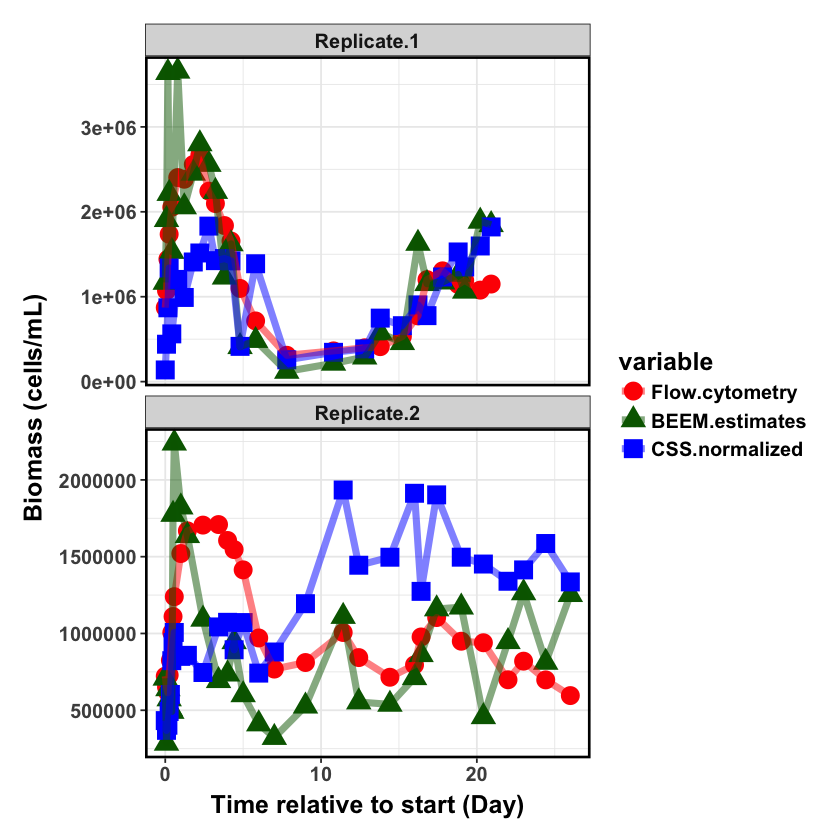

In [8]:
ggplot(melt(plot.dat.biomass, id.vars = list("time","replicate")), aes(x=time,y=value,pch=variable, col=variable)) +
    labs(x="Time relative to start (Day)",y="Biomass (cells/mL)") + 
        geom_point(size= 5) + geom_line(size=2, alpha=0.5)  + facet_wrap(~replicate,ncol=1,scale='free_y') +
            scale_color_manual(values=c('red','darkgreen','blue'))

## Scatter plot and Spearman correlations

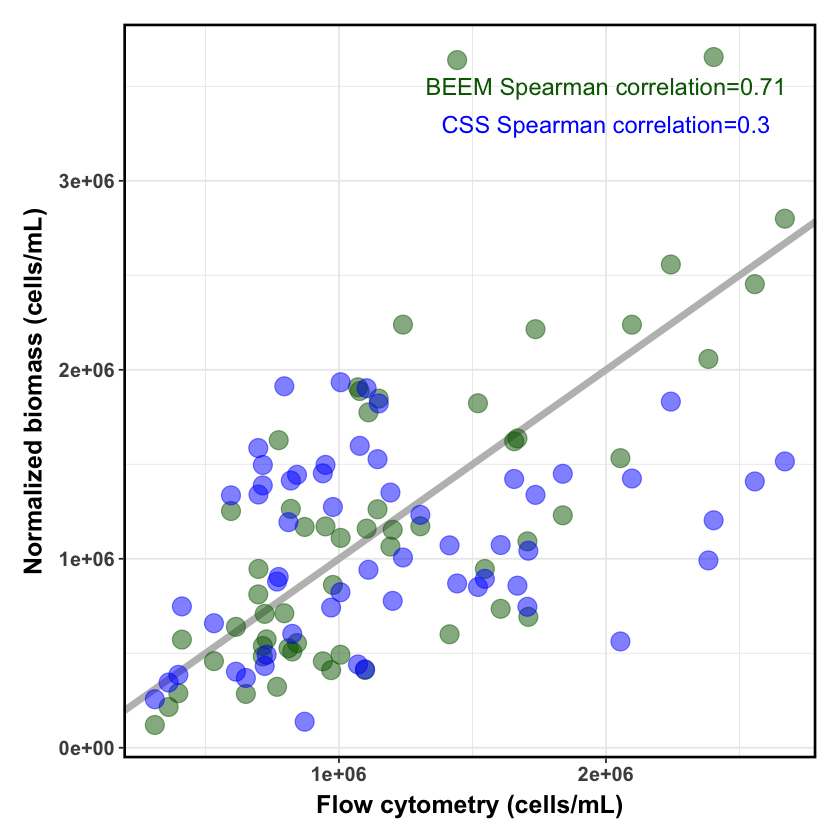

In [9]:
ggplot(plot.dat.biomass,aes(x=Flow.cytometry, y=BEEM.estimates)) +
    geom_abline(intercept = 0,slope=1, size=2, col='grey') +
    geom_point(size=5,col='darkgreen',alpha=0.5) + 
    labs(x='Flow cytometry (cells/mL)',y='Normalized biomass (cells/mL)') +
    geom_point(aes(x=Flow.cytometry,y=CSS.normalized), col='blue',size=5,alpha=0.5) + 
    annotate("text",x=2e6,y=3.5e6,size=5,label=paste0("BEEM Spearman correlation=",round(cor.test(biomass.true.sel,biomass, method='spearman')$estimate,2)),col='darkgreen') + 
    annotate("text",x=2e6,y=3.3e6,size=5,label=paste0("CSS Spearman correlation=",round(cor.test(biomass.true.sel,biomass.css.sel, method='spearman')$estimate,2)),col='blue')

## Relative error in biomass

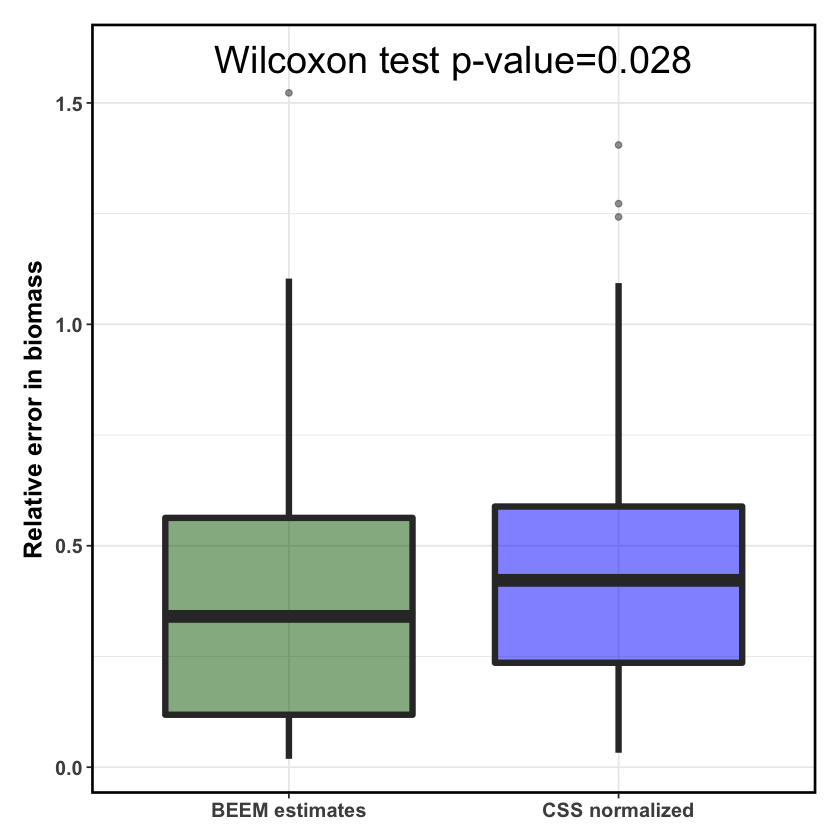

In [13]:
## function to compute relaitve error
rel_err <- function(a,b){
    a <- c(a)
    b <- c(b)
    tmp <- abs((a-b)/(a))
    ## 0/0 --> no error
    tmp[is.nan(tmp)] <- 0
    tmp 
}

beem.rel.err <- with(plot.dat.biomass, rel_err(Flow.cytometry,BEEM.estimates))
css.rel.err <- with(plot.dat.biomass, rel_err(Flow.cytometry,CSS.normalized))

c.dat <- rbind(data.frame(rel.err=beem.rel.err, method="BEEM estimates"),
               data.frame(rel.err=css.rel.err, method="CSS normalized"))

test.p <- round(wilcox.test(beem.rel.err,css.rel.err, alternative = 'less')$p.value,3)


ggplot(c.dat,aes(x=method,y=rel.err,fill=method)) +
    geom_boxplot(alpha=0.5, lwd=1.8) +
    labs(x=NULL,y='Relative error in biomass')+
    scale_fill_manual(values=c('darkgreen','blue'),guide='none') +
    annotate("text",x=1.5,y=1.6,size=8,label=paste0("Wilcoxon test p-value=",test.p))
